In [1]:
import numpy as np
import pylab as pl
from george import GP, kernels
%matplotlib inline

# What this notebook is about

In my research recently I have made extensive use of quasi-periodic Gaussian Process (QPGP for short) models, where the covariance function, or kernel, is the product of two terms: one strictly periodic and one monotonically decreasing function of Euclidean distance in the input space (which is typically 1-D for the applications I'm looking at). Specifically, I usually combine the exponential (sine squared) periodic kernel introduced by e.g. Mackay (1998) with the familiar squared exponential kernel, because random draws from the resulting composite kernel look remarkably similar to the stellar light curves I am working with. That being said, many other combinations are possible.

Despite having used this type of GP quite a bit, I still have a fairly hazy understanding of how the parameters of the kernel (i.e. the hyper-parameters of the GP) relate to properties of the resulting time-series, or vectors, that we might be able to relate to: for something like the period it is fairly obvious, but for things like number of wiggles per period (for want of a better expression), evolutionary time-scale, or even amplitude, things are more murky, and sometimes surprising (to me at least). What I really would like to understand better, ultimately, is the relationship between the hyper-parameters and the physical parameters of stellar surface structures, such as magnetically active regions and star spots, that give rise to the observed variability in the light curves I am studying. Physical properties of interest include active region or spot lifetimes, differential rotation, distribution of active regions over the stellar surface... But as a first step, in this notebook I am going to try to explore the relationship between the GP hyper-parameters and the basic properties of the resulting time-series.

# The building blocks

## The squared exponential kernel

This is defined as:

$$k_{\mathrm{SE}} (r) = V \exp{\left( -\frac{r^2}{2l^2} \right)},$$
    
where, if our input variable is $t$, $r \equiv |t-t'|$, $V$ controls the variance of the resulting time-series, and $l$ is their length scale (also known as input scale). 

#### Alternative parametrisations

Many alternative parametrisation are sometimes used, for example one can use an amplitude (or output scale) $a = \sqrt{V}$ instead of the variance hyper-parameter. Similaryl, one can use an inverse length scale $\eta \equiv l^{-1}$, or a "metric" $m \equiv 0.5 l^{-2}$ (the latter is used in *george*, for example), instead of the length scale $l$.

#### What does it actually look like?

Let's plot the covariance function for a few different values of $V$ and $l$, and then random draws from the corresponding GPs.

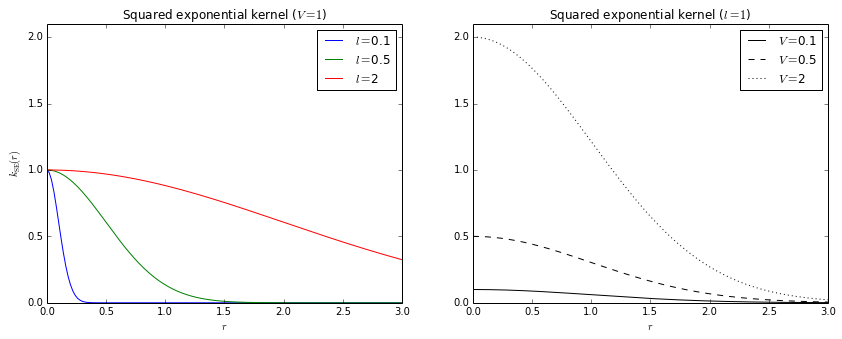

In [60]:
r = np.r_[0:5:251j]
def expsquared(l, r):
    return np.exp(-(r/l)**2/2)
pl.figure(figsize=(14,5))
cols = ['b','g','r']
lss = ['-', '--', ':']
l = [0.1,0.5,2]
V = [0.1,0.5,2]
ax1 = pl.subplot(121)
for i in range(len(l)):
    pl.plot(r,1*expsquared(l[i],r), label = r"$l=$%s" % repr(l[i]), c = cols[i])
pl.legend(loc=0)
pl.title(r"Squared exponential kernel ($V=1$)")
pl.xlabel(r"$r$")
pl.ylabel(r"$k_{\mathrm{SE}}(r)$")
ax2 = pl.subplot(122, sharex = ax1, sharey = ax1)
for i in range(len(V)):
    pl.plot(r,V[i]*expsquared(1,r), label = r"$V=$%s" % repr(V[i]), c = 'k', ls = lss[i])
pl.legend(loc=0)
pl.title(r"Squared exponential kernel ($l=1$)")
pl.xlabel(r"$r$")
pl.xlim(0,3)
pl.ylim(0,2.1);

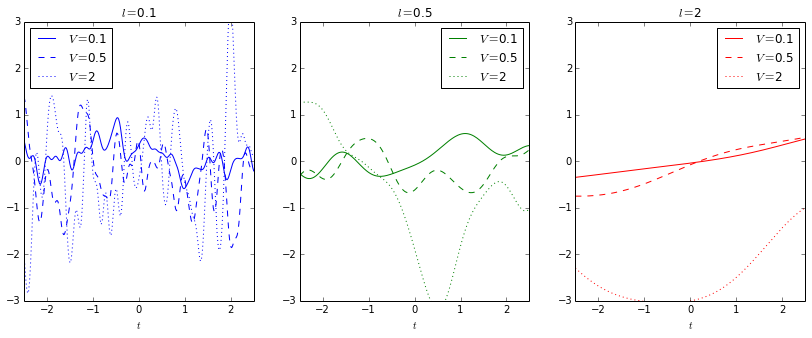

In [61]:
t = r - 2.5
pl.figure(figsize=(14,5))
for i in range(len(l)):
    if i == 0:
        ax1 = pl.subplot(131)
    else: 
        axc = pl.subplot(1,3,i+1, sharex = ax1, sharey = ax1)
    for j in range(len(V)):
        gp = GP(V[j] * kernels.ExpSquaredKernel(l[i]**2))
        gp.compute(t,yerr=1e-3)
        sam = gp.sample(t).flatten()
        pl.plot(t,sam,c=cols[i],ls=lss[j], label = r"$V=$%s" % repr(V[j]))
    pl.title(r"$l=$%s" % repr(l[i]))
    pl.legend(loc=0)
    pl.xlabel(r"$t$")
pl.xlim(-2.5,2.5)
pl.ylim(-3,3);

So as we'd expect, $V$ controls the amplitude and $l$ the "wigglyness" of the time-series. But can we be a bit more specific?

#### What does $l$ mean exactly?

It would be useful to understand the relationship between $l$ and the typical number of turning points, or zero crossings, per unit time. I don't have a good mathematical insight into this, but I can try to get at it empirically... Warning: the next cell takes a while to run.

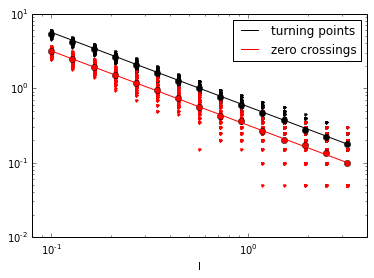

In [62]:
dt = np.r_[0:20:501j]
T = dt[-1]-dt[0]
logl = np.r_[-1:0.5:15j]
l = 10.0**logl
n = len(l)
nsim = 100
ntp = np.zeros((n,nsim))
def turningPoints(lst):
    dx = np.diff(lst)
    return (dx[1:] * dx[:-1] < 0)
nzc = np.zeros((n,nsim))
def zeroCrossings(lst):
    z = 0
    si = np.sign(lst)
    return (si[1:] * si[:-1] < 0)
for i in range(n):
    gp = GP(kernels.ExpSquaredKernel(l[i]**2))
    gp.compute(dt,yerr=1e-3)
    sam = gp.sample(dt, size = nsim)
    for j in range(nsim):
        tmp = sam[j,:].flatten()
        tp = turningPoints(tmp)
        ntp[i,j] = tp.sum()/float(T)
        zc = zeroCrossings(tmp)
        nzc[i,j] = zc.sum()/float(T)
ntp_mean = np.mean(ntp, axis=1)
nzc_mean = np.mean(nzc, axis=1)
for i in range(n):
    pl.plot(np.ones(nsim)*l[i], ntp[i,:].flatten(), 'k.')
    pl.plot(np.ones(nsim)*l[i], nzc[i,:].flatten(), 'r.')
pl.plot(l, ntp_mean, 'ko')
pl.plot(l, 10.0**(-0.25-np.log10(l)), 'k-', label = 'turning points')
pl.plot(l, nzc_mean, 'ro')
pl.plot(l, 10.0**(-0.5-np.log10(l)), 'r-', label = 'zero crossings')
pl.xlabel(r"$l$")
pl.legend(loc=0)
pl.loglog()
pl.xlim(0.08,4);

So, it looks like, for this kernel, the number of turning points per unit time is $n_{\mathrm{TP}} \approx 0.56/l$ and the number of zero crossings per unit time is $n_{\mathrm{ZC}} \approx 0.31/l$. Where these constants come from, I'm not sure, but the $1/l$ dependency makes sense, and also the fact that there are fewer zero crossing than turning points.

#### What does $V$ mean exactly?

$V$ should be equal the variance of the time series, this is kind of obvious. But I'm less clear about the relationship between the amplitude, or output scale ($\sqrt{V}$) and the actual peak-to-peak amplitude of the time-series.

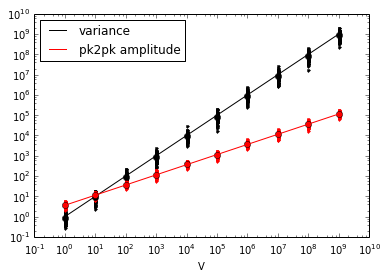

In [63]:
dt = np.r_[0:20:501j]
T = dt[-1]-dt[0]
l = 1.0
logV = np.arange(10) 
V = 10.0**logV
n = len(V)
nsim = 100
amp = np.zeros((n,nsim))
var = np.zeros((n,nsim))
for i in range(n):
    gp = GP(V[i] * kernels.ExpSquaredKernel(l**2))
    gp.compute(dt,yerr=V[i]*1e-3)
    sam = gp.sample(dt, size = nsim)
    for j in range(nsim):
        tmp = sam[j,:].flatten()
        var[i,j] = tmp.var()
        amp[i,j] = tmp.max() - tmp.min()
var_mean = np.mean(var, axis=1)
amp_mean = np.mean(amp, axis=1)
for i in range(n):
    pl.plot(np.ones(nsim)*V[i], var[i,:].flatten(), 'k.')
    pl.plot(np.ones(nsim)*V[i], amp[i,:].flatten(), 'r.')
pl.plot(V, var_mean, 'ko')
pl.plot(V, V, 'k-', label = 'variance')
pl.plot(V, amp_mean, 'ro')
pl.plot(V, 10.0**(0.56+0.5*np.log10(V)), 'r-', label = 'pk2pk amplitude')
pl.legend(loc=0)
pl.xlabel(r"$V$")
pl.loglog()
pl.xlim(0.1,1e10);

So the variance is equal to $V$, as expected. The amplitude is given by $A \approx 3.6 V^{0.5}$; once again the index is as expected but I'm not sure where the constant comes from.

## The exponential(sine squared) kernel

We now move to the strictly periodic kernel, which forms the second building block of our QPGP kernel. I use the exponential(sine squared) kernel, which is defined (once again following RW) as:

$$k_{\mathrm{P}} (r) = V \exp{\left( -\frac{2 \sin^2 (\pi r/P)}{l^2} \right)},$$

where $P$ is the period, $V$ controls the variance, and $l$ is a length or input scale. However, $V$ and $l$ don't have exactly the same interpretation as in the squared exponential kernel.

#### Origin

According to RW, this type of kernel was introduced by Mackay (1998), by mapping the one-dimensional variable $t$ onto a 2-D space $\mathbf{u}(t)=(\cos(t),\sin(t))$, and using the squared exponential kernel in $\mathbf{u}$-space. Noting that $(\cos(t)-\cos(t'))^2+(\sin(t)-\sin(t'))^2=4 \sin^2 (r/2)$, one obtains:

$$k(r) = \exp{\left( -\frac{2 \sin^2 (r/2)}{l^2} \right)}.$$

This provides some insight into the "meaning" of $l$: it is still a length scale, but in $\mathbf{u}$ space, not in the time domain itself. <font color=red>I need to think about this and what it means a little more.</font>

As $\sin^2(x)$ has period $\pi$, the above expression produces random periodic functions with period $2\pi$, the modified expression I used enables me to generate random periodic functions with arbitrary period $P$.

#### Alternative parametrisations

Once again, alternative parametrisations are sometimes used: in the past I have sometimes used $l' \equiv l/2$, and *george* uses $\Gamma \equiv 2 / l^2$.

#### What does it actually look like?

Let's plot the covariance function for a few different values of $P$, $V$ and $l$, and then random draws from the corresponding GPs.

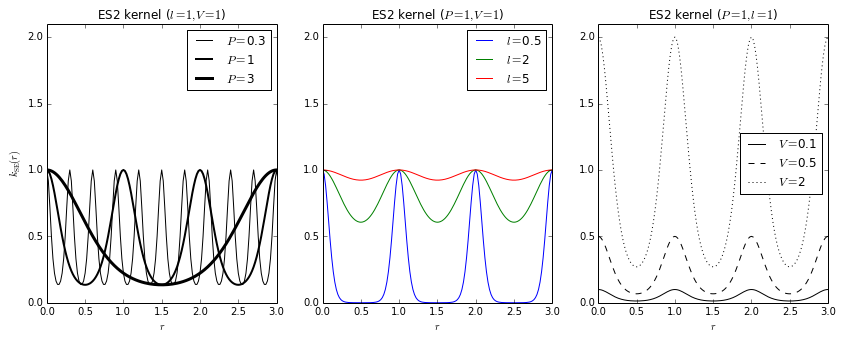

In [64]:
def expsine2(P, l, r):
    return np.exp(-2*(np.sin(np.pi*r/P))**2/l**2)
lws = [1,2,3]
cols = ['b','g','r']
lss = ['-', '--', ':']
P = [0.3,1,3]
l = [0.5,2,5]
V = [0.1,0.5,2]
pl.figure(figsize=(14,5))
ax1 = pl.subplot(131)
for i in range(len(P)):
    pl.plot(r,1*expsine2(P[i],1,r), label = r"$P=$%s" % repr(P[i]), lw = lws[i], c = 'k', ls = '-')
pl.legend(loc=0)
pl.title(r"ES2 kernel ($l=1,V=1$)")
pl.xlabel(r"$r$")
pl.ylabel(r"$k_{\mathrm{SE}}(r)$")
ax2 = pl.subplot(132, sharex = ax1, sharey = ax1)
for i in range(len(l)):
    pl.plot(r,1*expsine2(1,l[i],r), label = r"$l=$%s" % repr(l[i]), lw = 1, c = cols[i], ls = '-')
pl.legend(loc=0)
pl.title(r"ES2 kernel ($P=1,V=1$)")
pl.xlabel(r"$r$")
ax3 = pl.subplot(133, sharex = ax1, sharey = ax1)
for i in range(len(V)):
    pl.plot(r,V[i]*expsine2(1,1,r), label = r"$V=$%s" % repr(V[i]), lw = 1, c = 'k', ls = lss[i])
pl.legend(loc=0)
pl.title(r"ES2 kernel ($P=1,l=1$)")
pl.xlabel(r"$r$")
pl.xlim(0,3)
pl.ylim(0,2.1);

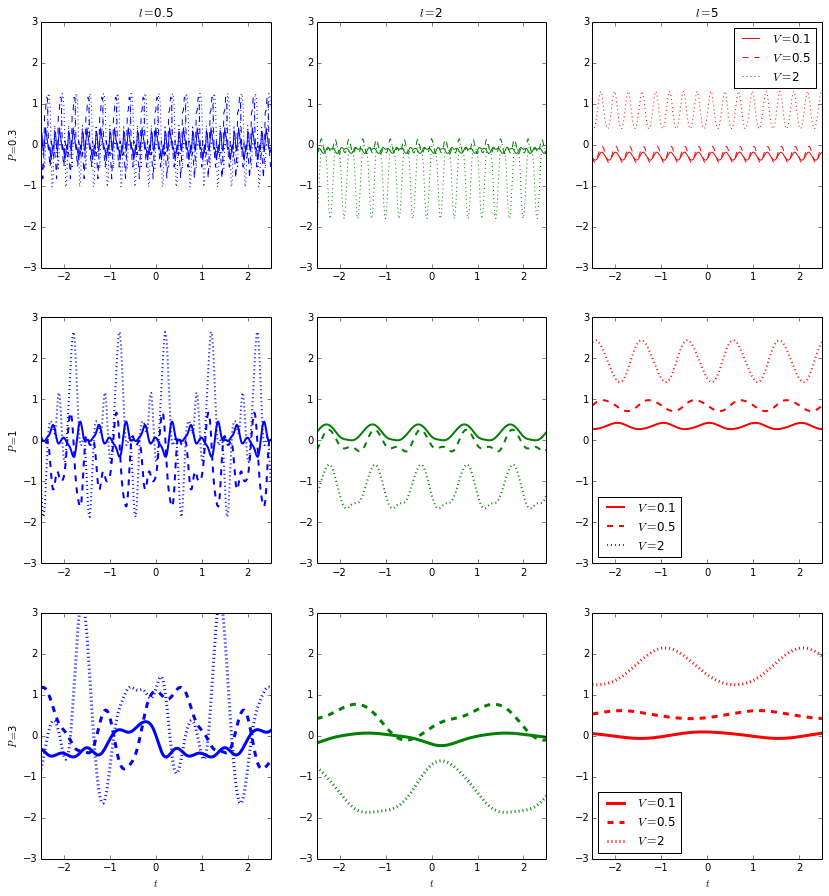

In [77]:
pl.figure(figsize=(14,15))
for i in range(len(P)):
    for j in range(len(l)):
        if (i == 0) & (j == 0):
            ax1 = pl.subplot(331)
        else: 
            axc = pl.subplot(3,3,i*3+j+1, sharex = ax1, sharey = ax1)
        Gamma = 2.0/l[j]**2
        for k in range(len(V)):
            gp = GP(V[k] * kernels.ExpSine2Kernel(Gamma,P[i]))
            gp.compute(t,yerr=1e-3)
            sam = gp.sample(t).flatten()
            pl.plot(t,sam,lw = lws[i], c=cols[j],ls=lss[k], label = r"$V=$%s" % repr(V[k]))
        if i == 0: 
            pl.title(r"$l=$%s" % repr(l[j]))
        if j == 0: 
            pl.ylabel(r"$P=$%s" % repr(P[i]))
        if i == len(P)-1:
            pl.xlabel(r"$t$")
        if j == len(l)-1:
            pl.legend(loc=0)
pl.xlim(-2.5,2.5)
pl.ylim(-3,3);

We can immediately see things are going to be a little more complicated than before. Obviously, $P$ controls the period, but the shape and range of the covariance function, and hence the "wigglyness", variance and even mean of the resulting time-series, depend on both $V$ and $l$ in an interconnected way.

Before we delve into that any deeper, though, a short aside...

#### Other periodic kernels

This isn't by any means the only way to create a periodic kernel. For example, another commonly used periodic kernel is the cosine kernel:

$$ k(r) = \cos \left(\frac{2 \pi r}{P} \right).$$

This is simpler, in that it doesn't have a scale hyper-parameter, but the big difference is that the covariance is forced to go to $-1$ for $r = nP + 0.5$, i.e. observations in antiphase have to be anticorrelated. In other words, this kernel is appropriate only for modelling harmonic signals that can be described just by sines and cosines with period $P$. This is very much appropriate for (e.g.) acoustic stellar oscillations, which is why Brewer & Stello (2009) recommend using it in that context, but it doesn't fit the bill for rotational modulation of evolving active regions.

By contrast, with the exponential(sine squared) kernel I am using, the covariance only drops to a value somewhere between 0 and 1 for $r = nP + 0.5$, and this is what enables it to model more complex periodic signals, including for example active star light curves displaying a characteristic "double dip" feature, which is commonly observed.

In principle one could construct periodic kernels even more specifically tailored to any particular task, and if we had more insights into the dynamics of the problem (i.e. the equations of motion governing the system we're trying to model) this would definitely be the way to go. However, I personally have no such insight in the context of active star light curves. For my purposes, the exponential(sine squared) kernel does a fine job in all the applications I've used it for so far, with a remarkably small number of hyper-parameters, so I'm sticking with it...

#### Variance and mean

One interesting and somewhat surprising property of this kernel is that, even if $V=1$, the variance of the resulting time-series isn't necessarily unity, and their mean isn't zero.

This is because, depending on the value of $l$ (or, equivalently, $\Gamma$), the covariance function doesn't necessarily go to zero -- ever. Specifically, the minimum value of the covarinace function, which occurs when $r = nP + 0.5$, such that $\sin^2(2 \pi r / P)$ = 1, is 

$$\min(k_{\mathrm{P}}) = V \exp \left( \frac{-2}{l^2} \right) = V \exp(-\Gamma),$$

while of course $\max(k_{\mathrm{P}}) = V$, so that

$$\mathrm{range}(k_{\mathrm{P}}) = V \left[ 1 - \exp \left( \frac{-2}{l^2} \right) \right] = V \left[ 1 - \exp(-\Gamma) \right].$$

So is it this range that controls the actual variance and mean of the time-series? Let's test that.

[]

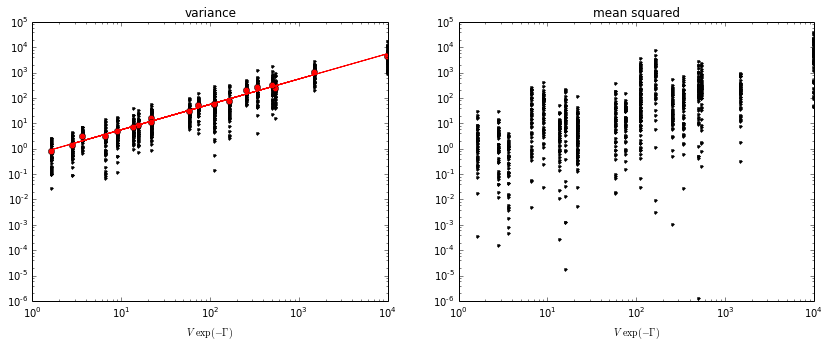

In [96]:
dt = np.r_[0:10:501j]
T = dt[-1]-dt[0]
P = 1.0
n = 20
nsim = 50
logV = np.random.uniform(0,5,size=n) 
logGamma = np.random.uniform(-1,1,size=n) 
V = 10.0**logV
Gamma = 10.0**logGamma
ran = V * (1-np.exp(-Gamma))
l = np.sqrt(2/Gamma)
var = np.zeros((n,nsim))
msq = np.zeros((n,nsim))
for i in range(n):
    gp = GP(V[i] * kernels.ExpSine2Kernel(Gamma[i],P))
    gp.compute(dt,yerr=V[i]*1e-3)
    sam = gp.sample(dt, size = nsim)
    for j in range(nsim):
        tmp = sam[j,:].flatten()
        var[i,j] = tmp.var()
        msq[i,j] = (tmp.mean()**2)
var_mean = np.mean(var, axis=1)
pl.figure(figsize=(14,5))
ax1 = pl.subplot(121)
for i in range(n):
    pl.plot(np.ones(nsim)*ran[i], var[i,:].flatten(), 'k.')
pl.plot(ran, var_mean, 'ro')
pl.plot(ran, 10.0**(-0.25+np.log10(ran)), 'r-')
pl.title('variance')
pl.xlabel(r"$V$ $\exp(-\Gamma)$")
pl.loglog()
ax2 = pl.subplot(122, sharex = ax1, sharey = ax1)
for i in range(n):
    pl.plot(np.ones(nsim)*ran[i], msq[i,:].flatten(), 'k.')
pl.title('mean squared')
pl.xlabel(r"$V$ $\exp(-\Gamma)$")
pl.loglog()


We can see the variance does scale like $V \exp(-\Gamma)$, as expected, though there is a proportionality factor of 0.56, the origin of which I don't understand. The mean (or rather, the range of the squared means) doesn't quite scale with $V \exp(-\Gamma)$; the dependence on $V$ and $\Gamma$ must be a bit different. 

# <font color=red> DONE TILL HERE</font>

### What does $l$ mean now?



#Periodic and quasi periodic kernels

##Periodic (sine squared) kernel

This kernel is defined as
$k_{\mathrm{Per}}(t,t') = \exp \left[ - \Gamma \sin^2 \left(\frac{\pi \Delta t}{P} \right) \right]$,
where $\Delta t = t-t'$, $\Gamma$ is the scale of the correlations and $P$ is the period. Let us take a look at the covariance function for various values of $\Gamma$.

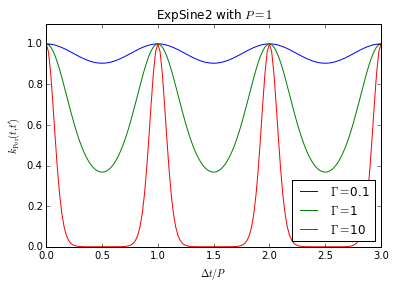

In [2]:
dt = np.r_[0:5:251j]
def expsine2(Gamma, P, dt):
    return np.exp(-Gamma*(np.sin(np.pi*dt/P))**2)
for Gamma in [0.1,1,10]:
    pl.plot(dt,expsine2(Gamma,1,dt), label = r"$\Gamma=$%s" % repr(Gamma))
pl.legend(loc='lower right')
pl.title(r"ExpSine2 with $P=1$")
pl.xlabel(r"$\Delta t/P$")
pl.ylabel(r"$k_{\mathrm{Per}}(t,t')$")
pl.xlim(0,3)
pl.ylim(0,1.1);

This clearly gives rise to strictly periodic functions with period $P$, as the covariance is 1 for $\Delta t = nP$. However, it would be nice to be able to relate the amplitude and length scale of the variations within a period to something more familiar. Let us compare the covariance function to the well known squared exponential kernel, defined as $k_{\mathrm{SE}}(t,t') = \exp \left[ - \frac{(\Delta t)^2}{2l^2} \right]$. 

In the squared exponential kernel, the covariance ranges from 1 to 0 and falls to $e^{-0.5}$ when $\Delta t=l$. The range sets the variance of the variations and $l$ their length scale. How the lenght scale relates to the number of turning points per unit time is something I'll want to investigate later.

In the periodic kernel we're considering, the covariance ranges from 1 to $e^{-\Gamma}$. The variance of the variations therefore scales as $1-e^{-\Gamma}$. 

The covariance falls to $e^{-0.5\Gamma}$ times its full range when $\Gamma \sin^2 \left(\frac{\pi \Delta t}{P} \right) = 0.5 \left( 1-e^{-\Gamma} \right)$, i.e. $\frac{\Delta t}{P} = \frac{1}{\pi} \arcsin\left( \sqrt{\frac{1-e^{-\Gamma}}{2\Gamma}}\right)$. This gives an estimate of the length scale of the variations within a period. </s></font>

NB1: For small $\Gamma$, the covariance never approaches zero, and this leads to functions which have non-zero mean, even over an infinite interval. Something similar happens with the squared exponential kernel for large $l$, but over a finite time interval $\Delta t \sim < l$.

NB2: for very small $\Gamma$, the variations look close to sinusoidal with period $P$.

Let's see if all this holds out in practice, by drawing samples from periodic and squared exponential GP priors with the appropriate parameters.

In [4]:
from george import GP, kernels
import time
def compare_per_se(P, Gamma, dt):
    gp_per = GP(kernels.ExpSine2Kernel(Gamma,P))
    gp_per.compute(dt,yerr=1e-3)
    seed = int(time.time())
    np.random.seed(seed)
    sam_per = gp_per.sample(dt,size=1)
    pl.plot(dt,sam_per.T,'k-', label = 'Per')
    pl.title(r"$P=$%s, $\Gamma=%s$" % (repr(P), repr(Gamma)))
    pl.xlabel(r"$t$")
    pl.ylabel(r"$f$")
    a_effective = np.sqrt(1 - np.exp(-Gamma))
    l_effective = (P/np.pi) * np.arcsin(np.sqrt((a_effective**2/2/Gamma)))
    print "amplitude=%.3f, length scale=%.3f" % (a_effective, l_effective)
    gp_se = GP(a_effective**2 * kernels.ExpSquaredKernel(l_effective**2))
    gp_se.compute(dt,yerr=1e-3)
    np.random.seed(seed)
    sam_se = gp_se.sample(dt,size=1)
    pl.plot(dt,sam_se.T,'k--', label = 'SE')
    pl.legend(loc=0)

amplitude=1.000, length scale=0.072


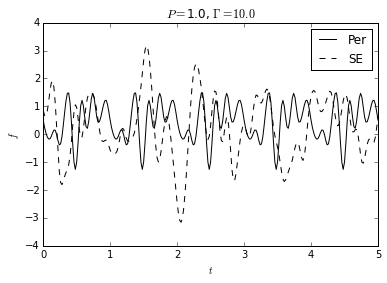

In [5]:
compare_per_se(1.0,10.0,dt)

amplitude=0.308, length scale=0.242


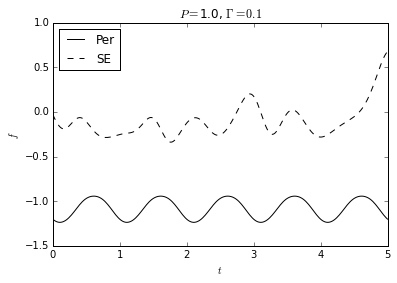

In [6]:
compare_per_se(1.0,0.1,dt)

amplitude=0.795, length scale=0.190


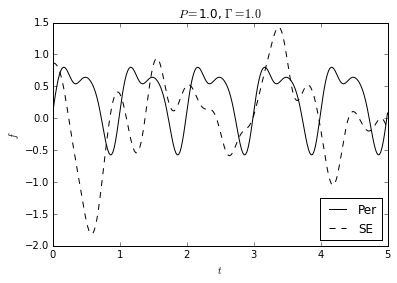

In [7]:
compare_per_se(1.0,1.0,dt)

This seems to give reasonable results for a wide range of $\Gamma$: the solid and dashed lines have similar amplitudes and length scales. Good!

## Quasi-periodic kernel

We can construct a quasi-periodic kernel by multiplying the periodic (ExpSine2) kernel by a squared exponential (or any other kernel, but let's stick to squared exponential for now). This is defined as:
$k_{\mathrm{QP}}(t,t') = \exp \left[ - \Gamma \sin^2 \left(\frac{\pi \Delta t}{P} \right) - \frac{(\Delta t)^2}{2L^2}\right]$. Let us take a look at the covariance function.

solid: Gamma=0.5, dashed: Gamma=5
blue: L=0.3, green: L=3, red: L=30


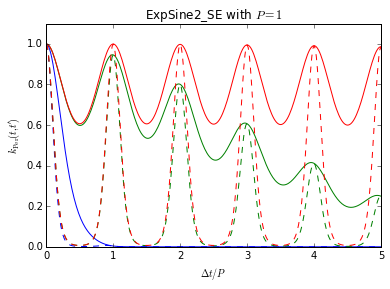

In [8]:
def expsine2_SE(Gamma, P, L, dt):
    return np.exp(-Gamma*(np.sin(np.pi*dt/P))**2 - dt**2/(2*L**2))
dt = np.r_[0:5:301j]
Gammas = [0.5,5]
Ls = [0.3,3,30]
lss = ['-', '--']
cols = ['b','g','r']
for i in range(len(Gammas)):
    Gamma = Gammas[i]
    ls = lss[i]
    for j in range(len(Ls)):
        L = Ls[j]
        col = cols[j]
        pl.plot(dt,expsine2_SE(Gamma,1,L,dt), \
                label = r"$\Gamma=$%s, $L=$%s" % (repr(Gamma), repr(L)), \
                ls = ls, c = col)
#pl.legend(loc='lower right')
pl.title(r"ExpSine2_SE with $P=1$")
pl.xlabel(r"$\Delta t/P$")
pl.ylabel(r"$k_{\mathrm{Per}}(t,t')$")
pl.xlim(0,5)
pl.ylim(0,1.1)
print "solid: Gamma=%s, dashed: Gamma=%s" % (Gammas[0], Gammas[1])
print "blue: L=%s, green: L=%s, red: L=%s" % (Ls[0], Ls[1], Ls[2])

For large $L$ (if $L \gg T$, where $T$ is the time span of the data), the behaviour is essentially the same as for the strictly periodic case. 

For small $L$ (if $L \ll P$), there are no subsidiary maxima, and the behaviour will look much like a squared exponential. However, if $\Gamma$ is small, it can still influence the length scale. <font color="red">_Probably need to double check this also_ <s> The covariance ranges for 0 to 1 but falls to $e^{-0.5}$ when $\Gamma \sin^2 \left(\frac{\pi \Delta t}{P} \right) + \frac{(\Delta t)^2}{2L^2}= 0.5$, i.e. when $(\Delta t)^2 = \frac{L^2 P^2}{2 \pi^2 L^2 \Gamma + P^2}$. In the extremes, the length scale can thus be approximated as $\Delta t \approx \frac{P}{\pi} \frac{1}{\sqrt{2\Gamma}}$ or $\Delta t \approx L$, whichever is the smaller.</s></font>

<font color=red>_This has an error in it too, started to correct it but need to follow through._
Now, what is the condition for there to be secondary maxima? Set $\frac{\partial}{\partial \Delta t} \left[ k_{\rm QP}(t,t') \right]=0$, this implies $\sin(2 \pi \Delta t / P) = - \frac{P^2 \Delta t}{\pi \Gamma L^2}$. <s>This always has a solution at $\Delta t = 0$, but at least two solutions for non-zero $\Delta t$ exist if $L^2 / \Gamma > 3 P / 4$. (I get this by requiring that $- \Gamma \Delta t / L^2$ be $>-1$ at the first minimum of the sinusoid, which occurs at $\Delta t = 3 P / 4$.) The first is a minimum and the second a maximum. </s></font>

<font color="red">_And probably will need to edit this too..._<s>If that condition is satisfied, then we genuinely have what we might call a quasi-periodic process. The number of subsidiary maxima is $n = \mathrm{floor} \left(\frac{1}{4} + \frac{L^2}{P \Gamma} \right)$. This is the maximum number of cycles for which the process "remembers" anything of what it was doing $n$ cycles ago (i.e. for which the covariance for $\Delta t = nP$ is larger than the covariance for $\Delta t = nP \pm \epsilon$).</s></font>

It is not, however, what we would normally think of as the overall evolutionary timescale of the process: that is given by the time interval for which the covariance has decayed by $e^{-0.5}$, which we can approximate as $L$. This approximation ignores the oscillatory component of the covarinace function and focuses on the exponential envelope only, but that's ok, because the evolutionary timescale is only constrained if the time span of the data is significantly longer than $L$, which is equivalent to saying that the periodic wobbles are small compared to the overall decay.

The approximation derived in the periodic case for the length scale of the variations within a cycle can still be used, though we should note that the smaller $L$ is, the worse an approximation it will be. 

Finally, provided $L^2 / \Gamma > 3 P / 4$ and the time span $T$ of the observations exceeds $P$ (i.e. there are subsidiary minima and maxima in the covariance function as evaluated over $\Delta t \le T$), the minimum of the covariance occurs at $\Delta t = (n-1/2)P$ where $n=\mathrm{floor}(T/P)$, at which point $k_{\rm QP} \approx \exp \left( - \Gamma - \frac{T^2}{2L^2} \right)$. So the variance of the functions this process generates, when evaluated over time span $T$, is approximately given by $1-\exp \left( - \Gamma - \frac{T^2}{2L^2} \right)$.

Next I should look at how well this bears out in practice. But I've run out fo time for today.

In [9]:
def compare_QP_se(P, Gamma, L, dt):
    gp_QP = GP(kernels.ExpSine2Kernel(Gamma,P) * kernels.ExpSquaredKernel(L**2))
    gp_QP.compute(dt,yerr=1e-3)
    seed = int(time.time())
    np.random.seed(seed)
    sam_QP = gp_QP.sample(dt,size=1)
    pl.plot(dt,sam_QP.T,'k-', label = 'Per')
    pl.title(r"$P=$%s, $\Gamma=%s$,$L=$%s" % (repr(P), repr(Gamma), repr(L)))
    pl.xlabel(r"$t$")
    pl.ylabel(r"$f$")
    if (L**2/Gamma) < (3*P/4):
        print 'No secondary covariance maxima: process is not periodic'
        l_effective = min(P/np.pi/np.sqrt(2*Gamma), L)
        a_effective = 1.0
        l_evol = np.nan
    else:
        l_evol = L
        a_effective = np.sqrt(1 - np.exp(-Gamma))
        l_effective = (P/np.pi) * np.arcsin(np.sqrt((a_effective**2/2/Gamma)))
    print "amplitude=%.3f, length scale=%.3f, evolutionary length scale %.1f" % (a_effective, l_effective, l_evol)
    gp_se = GP(a_effective**2 * kernels.ExpSquaredKernel(l_effective**2))
    gp_se.compute(dt,yerr=1e-3)
    np.random.seed(seed)
    sam_se = gp_se.sample(dt,size=1)
    pl.plot(dt,sam_se.T,'k--', label = 'SE')
    if np.isfinite(l_evol):
        gp_se2 = GP(a_effective**2 * kernels.ExpSquaredKernel(l_evol**2))
        gp_se2.compute(dt,yerr=1e-3)
        np.random.seed(seed)
        sam_se2 = gp_se2.sample(dt,size=1)
        pl.plot(dt,sam_se2.T,'k:', label = 'Evol')
    pl.legend(loc=0)

No secondary covariance maxima: process is not periodic
amplitude=1.000, length scale=0.300, evolutionary length scale nan


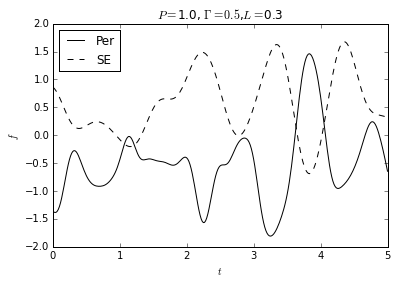

In [27]:
compare_QP_se(1.0, .5, .3, dt) # should be aperiodic with length scale ~ L

No secondary covariance maxima: process is not periodic
amplitude=1.000, length scale=0.101, evolutionary length scale nan


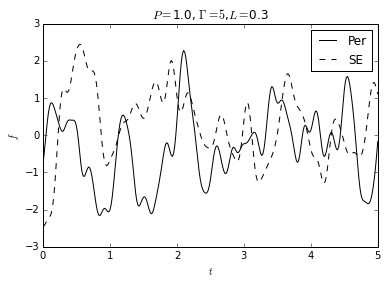

In [28]:
compare_QP_se(1.0, 5, .3, dt) # should be aperiodic with shorter length scale ~ 1/pi/sqrt(2Gamma)

amplitude=0.627, length scale=0.216, evolutionary length scale 3.0


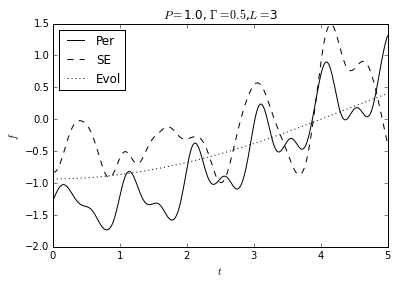

In [29]:
compare_QP_se(1.0, .5, 3, dt) 
# Should be periodic with evol timescale ~ L, total variance slightly < 1, 
# a few wiggles per period with smaller than overall variance

amplitude=0.997, length scale=0.102, evolutionary length scale 3.0


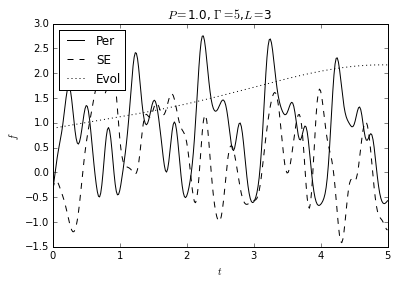

In [31]:
compare_QP_se(1.0, 5, 3, dt) 
# Should be periodic with evol timescale ~ L, total variance slightly ~ 1, 
# many wiggles per period with bigger variance

amplitude=0.627, length scale=0.216, evolutionary length scale 10.0


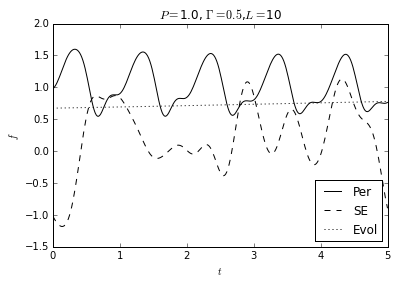

In [32]:
compare_QP_se(1.0, .5, 10, dt) 

amplitude=0.997, length scale=0.102, evolutionary length scale 10.0


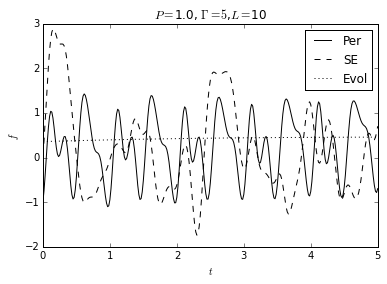

In [33]:
compare_QP_se(1.0, 5, 10, dt) 

All seems to behave as expected... Pfew!

This is encouraging because it means we have a way of relating the parameters of the QP GP kernel as defined above to properties of the time series that are themselves closely related to physical things we might be tryin to model like the lifetime and longitudinal distribution of active regions on a star.